In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gym

%matplotlib inline

Define Epsilon Greedy Exploration

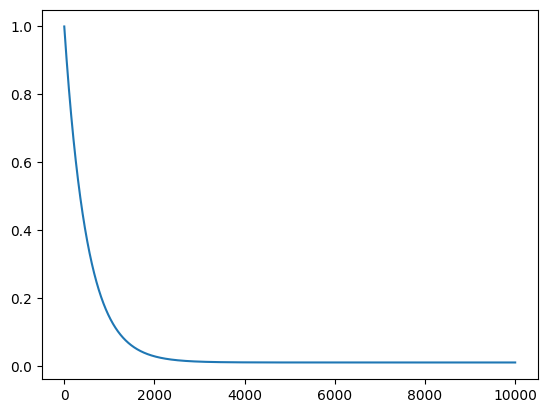

In [ ]:
# Define Epsilon Greedy Exploration
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(10000)])
plt.show()

Define ReplayBuffer Class

In [ ]:
# Define ReplayBuffer Class
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

Deep Q Network

In [ ]:
# Define Deep Q-Network (DQN) Model
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

    def forward(self, x):
        return self.layers(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

Computing Temporal Difference Loss

In [ ]:
# Define Temporal Difference Loss Computation
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done = torch.FloatTensor(done)

    q_values = model(state)
    next_q_values = model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [ ]:
# Define Plotting Function
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

Training

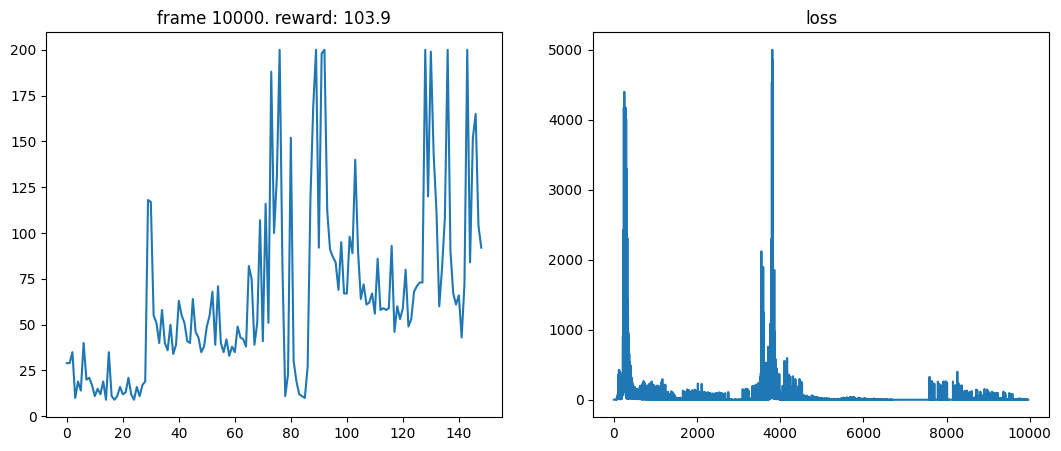

In [ ]:
# CartPole Training
env_id = "CartPole-v0"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

num_frames = 10000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss)

    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

Atari Environment Training

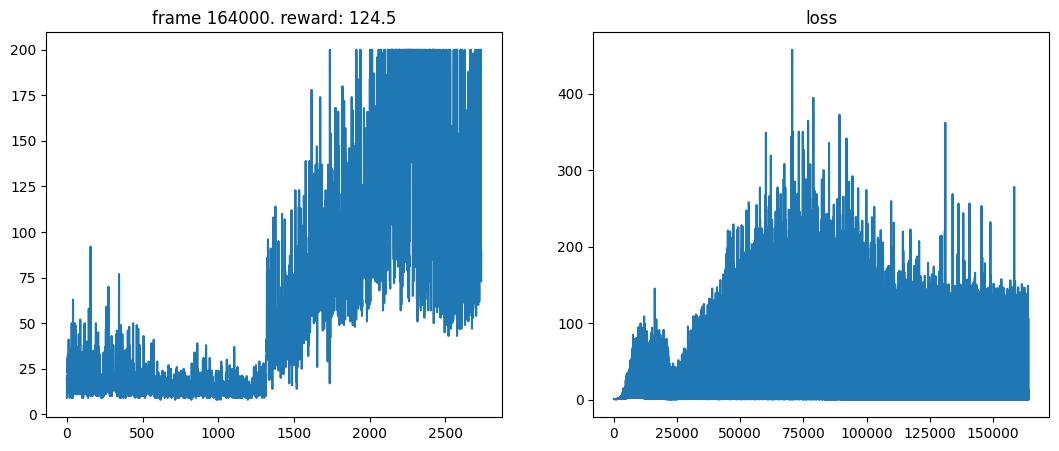

KeyboardInterrupt: 

In [ ]:
# Atari Environment Training
env_id = "CartPole-v0"
env = gym.make(env_id)

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        # Assuming input_shape is (1, 4), reshape to (4)
        self.features = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

    def forward(self, x):
        return self.features(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.num_actions)
        return action


model = CnnDQN(env.observation_space.shape, env.action_space.n)

optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 1400000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss)

    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses)